#### Example dataframe-dataset generator:

In [1]:
import sys
print(sys.executable)

/Users/Sherri/miniforge3/envs/m1ml2/bin/python


In [2]:
dic = {'first':[x for x in range(10)], 
       'second': [x**2 for x in range(10)],
        'third': [np.sqrt(x) for x in range(10)]}
data_ = pd.DataFrame(dic)
data_

NameError: name 'np' is not defined

In [3]:
w2 = WindowGenerator(input_width=3, label_width=2, shift=2
                     )

NameError: name 'WindowGenerator' is not defined

In [4]:
w2

NameError: name 'w2' is not defined

In [5]:
inputs,labels = w2.create_dataset(data_, stride=2)

NameError: name 'w2' is not defined

In [ ]:
inputs

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

In [3]:
print(tf.keras.__version__)

2.4.0


In [4]:
df = pd.read_csv('../datasets/df_feat_enged')

In [5]:
# split data
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [6]:
# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [7]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.000047,1.414246,-0.062412,1.428455
1,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.366088,1.366061,-0.061389,1.428445
2,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,0.707185,1.224790,-0.060366,1.428434
3,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.000091,1.000059,-0.059343,1.428423
4,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.224845,0.707185,-0.058320,1.428411


In [8]:
class WindowGenerator():
    def __init__(self, input_width=24, label_width=1, shift=1,    
               feature_columns=None, label_columns=None):


        # Work out the label and features column indices.
        self.feature_columns = feature_columns
        self.label_columns = label_columns
        # Number of output features
 
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + self.shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        print(self.label_start, self.labels_slice, self.label_indices)

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}',
            f'Feature column name (s): {self.feature_columns}'])
    
    def create_dataset(self, data, stride=1, shuffle=False):
        
        # work out the column indices of data
        self.column_indices = {name: i for i, name in
                               enumerate(data.columns)}
        
        data_set = []
        j= np.arange(0, len(data)- self.total_window_size, stride)
        for i in j:        
            v = data.iloc[i:(i + self.total_window_size)].values
            data_set.append(v) 
        
        final_dataset = np.array(data_set, dtype='object')      
        if shuffle: 
            np.random.shuffle(final_dataset)
        
        return self.split_window(final_dataset)
    
    def split_window(self, dataset):
        
        inputs = dataset[:, self.input_slice, :]
        labels = dataset[:, self.labels_slice, :]        
        
        if self.feature_columns is not None:
            inputs = np.stack(
            [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
        axis=-1)
            self.number_input_features = len(self.feature_columns)
        else:
            self.number_input_features = len(self.column_indices)
            
                
        if self.label_columns is not None:
            labels = np.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)   
            self.number_label_features = len(self.label_columns)
        else:
            self.number_label_features = len(self.column_indices)

        return inputs.astype("float64"), labels.astype("float64")


In [9]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
                     feature_columns=['p (mbar)', 'Day sin', 'max Wx'],
                     label_columns=['p (mbar)'])
w1

47 slice(47, None, None) [47]


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['p (mbar)']
Feature column name (s): ['p (mbar)', 'Day sin', 'max Wx']

In [10]:
len(train_df)

49063

In [11]:
inputs, labels = w1.create_dataset(train_df)
print(inputs.shape, labels.shape)
inputs, labels = w1.create_dataset(val_df)
print(inputs.shape, labels.shape)

(49015, 24, 3) (49015, 1, 1)
(13970, 24, 3) (13970, 1, 1)


In [12]:
w1.number_input_features

3

In [13]:
w1.label_columns

['p (mbar)']

### trying different NNs: Dense, Conv, LSTM

In [19]:
window = WindowGenerator(label_width=15, input_width=24, feature_columns=['p (mbar)', 'T (degC)', 'VPdef (mbar)'], 
                         label_columns=['p (mbar)', 'T (degC)', 'VPdef (mbar)'], shift=15)


24 slice(24, None, None) [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [20]:
window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): ['p (mbar)', 'T (degC)', 'VPdef (mbar)']
Feature column name (s): ['p (mbar)', 'T (degC)', 'VPdef (mbar)']

In [21]:
inputs_train, labels_train = window.create_dataset(train_df)
inputs_val, labels_val = window.create_dataset(val_df)
inputs_test, labels_test = window.create_dataset(test_df)

In [22]:
print(inputs_train.shape, labels_train.shape, inputs_val.shape, labels_val.shape)

(49024, 24, 3) (49024, 15, 3) (13979, 24, 3) (13979, 15, 3)


### Dense NNs:

In [88]:
# multi_step_dense.reset_states()
tf.keras.backend.clear_session()

In [89]:
def dense_model(window, units=10):
    model = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=units, activation='relu', 
                           # activity_regularizer=tf.keras.regularizers.l2(1e-3)
                         ),
    tf.keras.layers.Dense(units=(window.label_width * window.number_label_features)),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
     tf.keras.layers.Reshape([window.label_width, window.number_label_features])
                               ])
    return model

In [90]:
def compile_and_fit(model, X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val, patience=5,
                    batch_size=32, max_epochs=30):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(X, y, epochs=max_epochs,batch_size=batch_size,
                      validation_data=(val_X,val_y),
                      callbacks=[early_stopping])
    return history

In [91]:
model = dense_model(units=10, window=window)

In [94]:
history = compile_and_fit(model)

#IPython.display.clear_output()

model.summary()

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1372/1532 [=========================>....] - ETA: 0s - loss: 0.1345 - mean_absolute_error: 0.2323WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17c7d39d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

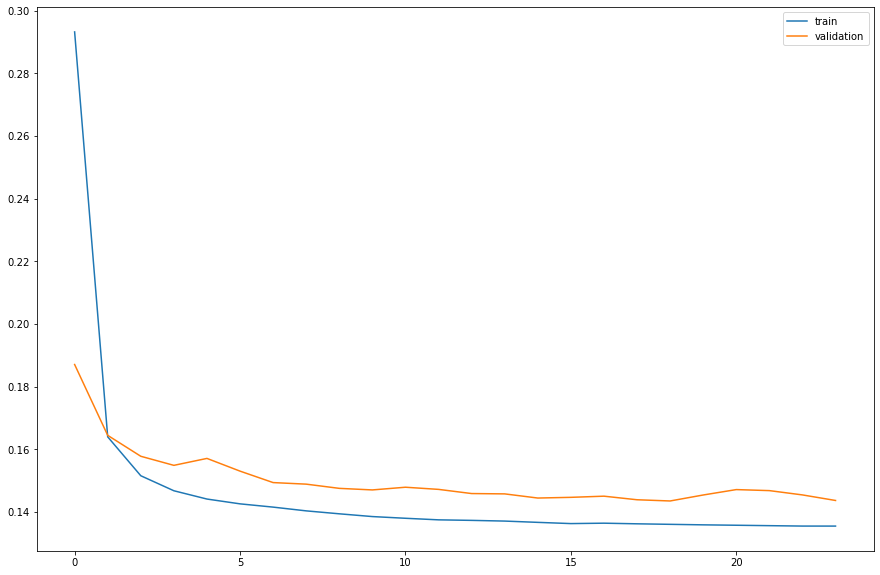

In [93]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [169]:
history.history['val_loss'][0], history.history['val_loss'][-1]

(0.2503531873226166, 0.21197330951690674)

In [170]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(mean_squared_error(labels_test.flatten(), np.array(model(inputs_test)).flatten()),
mean_absolute_error (labels_test.flatten(), np.array(model(inputs_test)).flatten()))

0.20384437414764903 0.29139334695201075


In [171]:
results = model.evaluate(inputs_test, labels_test)
results

218/218 [==============================] - 0s 321us/step - loss: 0.2038 - mean_absolute_error: 0.2914


[0.20384444296360016, 0.2913932800292969]

In [213]:
def plot_forecast(model, input_data=inputs_test,
                  label_data=labels_test, 
                  window=window, plot_col='T (degC)'):
    
    if label_data.shape[2] == 1:
        label_col_index = 0
    elif label_data.shape[2] > 1:
        label_col_index = window.column_indices[plot_col]
        
    if input_data.shape[2] == 1:
        input_col_index = 0
    elif input_data.shape[2] > 1:
        input_col_index = window.column_indices[plot_col]   
    
    preds = model.predict(input_data)     
    plt.plot(window.label_indices, label_data[-12, :, label_col_index], 'bo-',label='labels')
    plt.plot(window.input_indices, input_data[-12, :, input_col_index],'go-', label='inputs')         
    plt.plot(window.label_indices, preds[-12, :, label_col_index], 'ro', label= 'predictions')
    plt.legend(loc='best')
    plt.xlabel('time index')
    plt.ylabel(plot_col)
    return

In [214]:
inputs_test.shape, labels_test.shape

((6971, 24, 19), (6971, 15, 19))

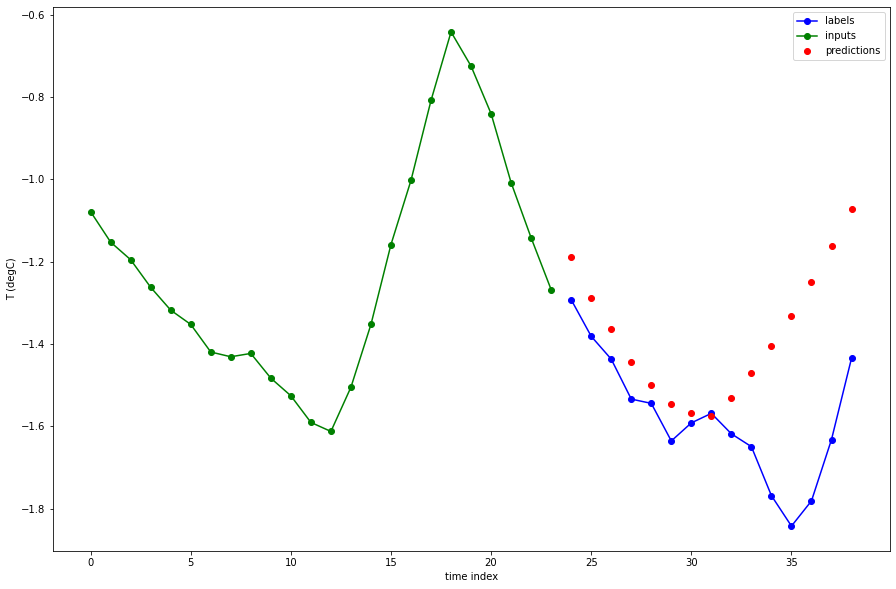

In [227]:
plot_forecast(model, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)')       

### Recursive class:

In [87]:
# first step is to create a one step output model: label_width=1


In [4]:
class Recursive_Forecast(WindowGenerator):
    def __init__(self, output_time_step=15, input_width=24,    
               feature_columns=None, label_columns=None):
        super().__init__(input_width=24,    
               feature_columns=None, label_columns=None)
        self.output_time_step = output_time_step
        self.label_width = 1
        self.shift = 1
        
    def datasets(self, train_set=train_df, valid_set=val_df, test_set=test_df):
        self.inputs_train,self.labels_train = self.create_dataset(train_set)
        self.inputs_val,self.labels_val = self.create_dataset(valid_set) 
        self.inputs_test,self.labels_test = self.create_dataset(test_set) 
        print("train_set inputs and labels shape:{}{}\n"
              "valid_set inputs and labels shape:{}{}\n"
              "test_set inputs and labels shape:{}{}".format(self.inputs_train.shape, self.labels_train.shape,
                                                             self.inputs_val.shape, self.labels_val.shape,
                                                             self.inputs_test.shape, self.labels_test.shape))        
    def model_fit(self, model, patience=5,batch_size=32, max_epochs=30):  
        self.model = model(window=self)
        self.history = compile_and_fit(self.model, 
                                       X=self.inputs_train, y=self.labels_train,
                                       val_X=self.inputs_val, val_y=self.labels_val,
                                       patience=patience, batch_size=batch_size,
                                       max_epochs=max_epochs)        
        IPython.display.clear_output()        
    
    def recursive_predictions(self, inputs, labels):
        if (self.number_input_features != self.number_label_features):
             raise ValueError("The number of input and output features should "
                               "be equal for a recursive prediction")
        output = np.array(self.model(inputs)) 
        dim1, dim2, dim3 = output.shape
        predictions = np.zeros((dim1, self.output_time_step, dim3))
        for n in range(self.output_time_step):
            prediction = np.array(self.model(inputs))        
            predictions[:, n:n+1, :] = prediction       
            inputs = inputs[:, -(self.input_width-1):, :] 
            inputs = np.concatenate((inputs, prediction), axis=1)        
        self.predictions = predictions[:(dim1-self.output_time_step+1), :, :]          
        
        labels_revived = np.zeros(self.predictions.shape)
        for i in range(labels_revived.shape[0]):         
            labels_revived[i, :, :] = labels[i:self.output_time_step+i, :, :].reshape(self.output_time_step, -1)
        self.labels = labels_revived
        
        return self.predictions, self.labels 
    
    
    def plot_forecast_recursive(self, inputs, plot_col='T (degC)'):
        
        dim1 = inputs.shape[0]
        input_data = inputs[:(dim1-self.output_time_step+1), :, :]
        print(input_data.shape)
        
        if self.labels.shape[2] == 1:
            label_col_index = 0
        elif self.labels.shape[2] > 1:
            label_col_index = self.column_indices[plot_col]
        if input_data.shape[2] == 1:
            input_col_index = 0
        elif input_data.shape[2] > 1:
            input_col_index = self.column_indices[plot_col]  
            
        output_index_start = self.input_indices[-1] + 1
        
        label_indices = np.arange(output_index_start, self.output_time_step + output_index_start)
       
        
        plt.plot(label_indices, self.labels[-1, :, label_col_index], 'bo-',label='labels')
        plt.plot(self.input_indices, input_data[-1, :, input_col_index],'go-', label='inputs')         
        plt.plot(label_indices, self.predictions[-1, :, label_col_index], 'ro', label= 'predictions')
        plt.legend(loc='best')
        plt.xlabel('time index')
        plt.ylabel(plot_col)

NameError: name 'train_df' is not defined

In [1]:
recur = Recursive_Forecast(output_time_step=15, input_width=15)


NameError: name 'Recursive_Forecast' is not defined

In [374]:
recur.label_start

24

In [310]:
recur.datasets()


train_set inputs and labels shape:(49038, 24, 19)(49038, 1, 19)
valid_set inputs and labels shape:(13993, 24, 19)(13993, 1, 19)
test_set inputs and labels shape:(6985, 24, 19)(6985, 1, 19)


In [311]:
recur.model_fit(dense_model, patience=5, max_epochs=30)

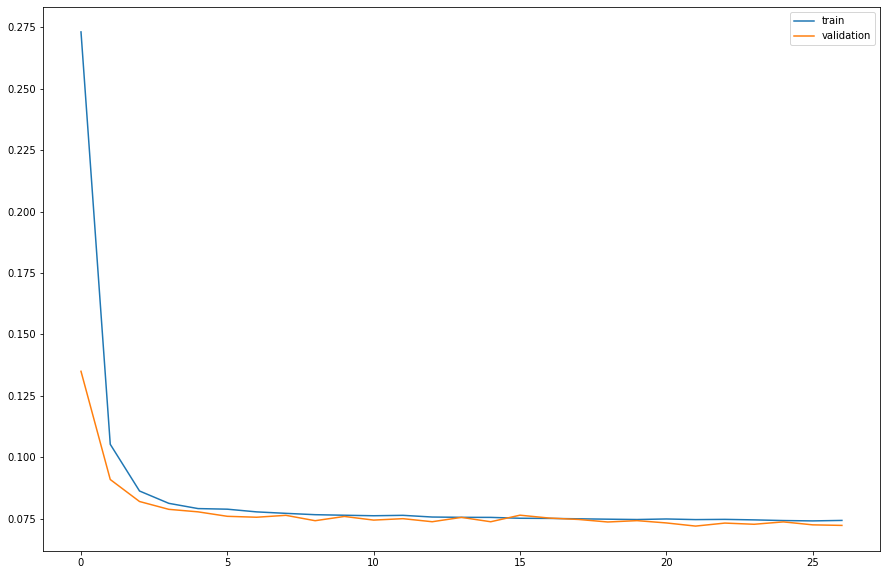

In [312]:
import matplotlib.pyplot as plt 

plt.plot(recur.history.history['loss'], label='train')
plt.plot(recur.history.history['val_loss'], label='validation')
plt.legend();

In [313]:
recur.history.history['val_loss'][0], recur.history.history['val_loss'][-1]

(0.13500112295150757, 0.07224893569946289)

In [336]:
labels, preds = recur.recursive_predictions(inputs=recur.inputs_test, labels=recur.labels_test)

In [337]:
# evaluate the recursive function

mean_squared_error(labels.flatten(), preds.flatten()), mean_absolute_error (labels.flatten(), preds.flatten())

(0.26257500341423334, 0.33290200296305045)

In [338]:
labels.shape

(6971, 15, 19)

(6971, 24, 19)


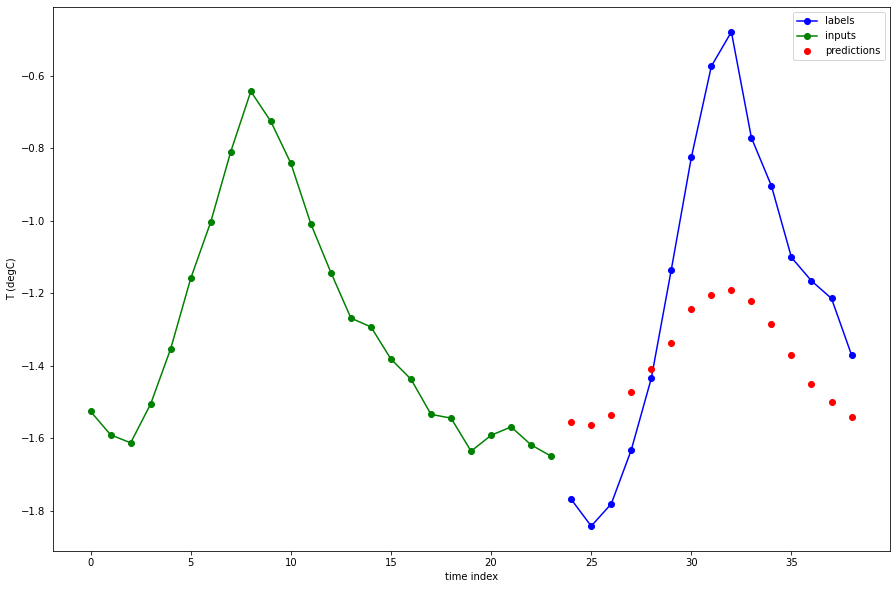

In [339]:
recur.plot_forecast_recursive(inputs=recur.inputs_test, plot_col='T (degC)')

### recursive model-separated parts:

In [319]:
# multistep models:
window_cur = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=1)

24 slice(24, None, None) [24]


In [320]:
window_cur

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): None
Feature column name (s): None

In [321]:
inputs_train_c, labels_train_c = window_cur.create_dataset(train_df)
inputs_val_c, labels_val_c = window_cur.create_dataset(val_df)
inputs_test_c, labels_test_c = window_cur.create_dataset(test_df)

In [322]:
print(inputs_train_c.shape, labels_train_c.shape, inputs_val_c.shape
      , labels_val_c.shape,inputs_test_c.shape, labels_test_c.shape)



(49038, 24, 19) (49038, 1, 19) (13993, 24, 19) (13993, 1, 19) (6985, 24, 19) (6985, 1, 19)


In [323]:
tf.keras.backend.clear_session()

In [324]:
model_cur = dense_model(units=10, window=window_cur)

In [325]:
history = compile_and_fit(model_cur, X=inputs_train_c,y=labels_train_c,
                    val_X=inputs_val_c, val_y=labels_val_c, patience=5,
                    batch_size=32, max_epochs=30 )

IPython.display.clear_output()

model_cur.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 456)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4570      
_________________________________________________________________
dense_1 (Dense)              (None, 19)                209       
_________________________________________________________________
reshape (Reshape)            (None, 1, 19)             0         
Total params: 4,779
Trainable params: 4,779
Non-trainable params: 0
_________________________________________________________________


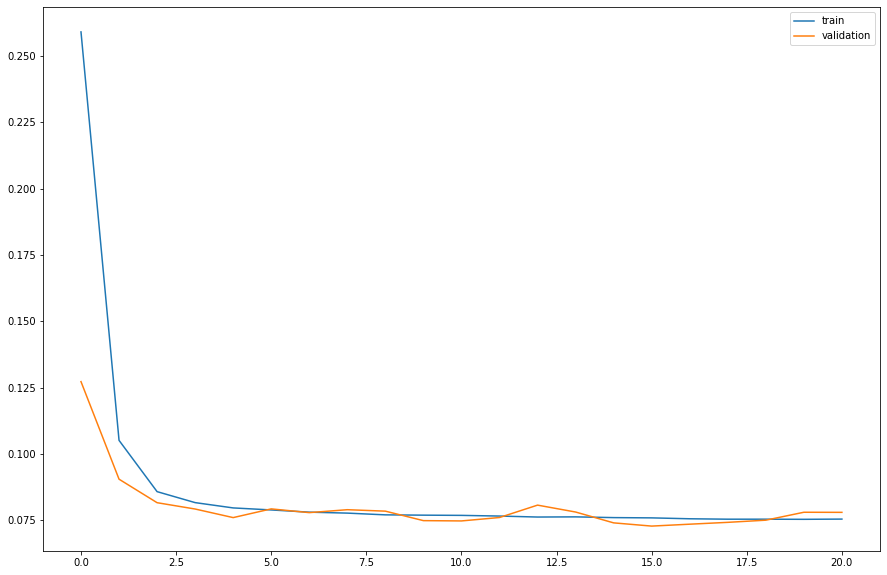

In [326]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [327]:
history.history['val_loss'][0], history.history['val_loss'][-1]

(0.12722012400627136, 0.07795245200395584)

In [328]:
def recursive_model(model, inputs, output_time_step):
    
    # for this recursive model the number of features in the input and outputs
    # of the model must be the same
    
    dim1, _, dim2 = model(inputs).shape   
    predictions = np.zeros((dim1, output_time_step, dim2))
    time_index = inputs.shape[1]
    for n in range(output_time_step):
        prediction = np.array(model(inputs))
        predictions[:, n:n+1, :] = prediction       
        inputs = inputs[:, -(time_index-1):, :]     
        inputs = np.concatenate((inputs, prediction), axis=1)
    return predictions[:(dim1-output_time_step+1), :, :]


In [340]:
pr = recursive_model(model_cur, inputs_test_c, output_time_step=15)
print(pr.shape)

(6971, 15, 19)


In [341]:
def revive_labels_recursive(output_time_step, labels=labels_val_c, predictions=pr):    

    labels_revived = np.zeros(predictions.shape)
    for i in range(labels_revived.shape[0]):         
        labels_revived[i, :, :] = labels[i:output_time_step+i, :, :].reshape(output_time_step, -1)
    return labels_revived

In [342]:
labels_revived = revive_labels_recursive(15, labels=labels_test_c, predictions=pr)
              

In [343]:
labels_revived.shape, pr.shape

((6971, 15, 19), (6971, 15, 19))

In [344]:
# evaluate the recursive function
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(labels_revived.flatten(), pr.flatten()), mean_absolute_error (labels_revived.flatten(), pr.flatten())

(0.3513783118984767, 0.38434749081324704)

In [345]:
## plot it
def plot_forecast_recursive(model, input_data=inputs_test_c,
                  label_data=labels_revived, output_time_step=24, 
                  recursive_preds = pr,     
                  window=window, plot_col='T (degC)'):
    
    dim1 = input_data.shape[0]
    input_data = input_data[:(dim1-output_time_step+1), :, :]
    
    if label_data.shape[2] == 1:
        label_col_index = 0
    elif label_data.shape[2] > 1:
        label_col_index = window.column_indices[plot_col]
        
    if input_data.shape[2] == 1:
        input_col_index = 0
    elif input_data.shape[2] > 1:
        input_col_index = window.column_indices[plot_col]   
    print(label_col_index, input_col_index) 
      
    output_index_start = window.input_indices[-1] + 1
    label_indices = np.arange(output_index_start, output_time_step + output_index_start)
    
    
    print(window.input_indices)
    print(input_data[-1, :, input_col_index])
    print(label_indices)
    print(label_data[-1, :, label_col_index])

    plt.plot(label_indices, label_data[-2, :, label_col_index], 'bo-',label='labels')
    plt.plot(window.input_indices, input_data[-2, :, input_col_index],'go-', label='inputs')         
    plt.plot(label_indices, recursive_preds[-2, :, label_col_index], 'ro', label= 'predictions')
    plt.legend(loc='best')
    plt.xlabel('time index')
    plt.ylabel(plot_col)
    return

1 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[-1.59078986 -1.61274261 -1.50528965 -1.35277577 -1.1586672  -1.00268709
 -0.80857852 -0.64219974 -0.72538913 -0.84092995 -1.00846413 -1.14249148
 -1.26843098 -1.29269455 -1.38166098 -1.43712057 -1.53417486 -1.54457353
 -1.63585078 -1.59194527 -1.5688371  -1.61851966 -1.64971568 -1.76872272]
[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[-1.84266884 -1.78143221 -1.63238455 -1.43480975 -1.13440363 -0.82475423
 -0.57287525 -0.47813178 -0.77045005 -0.90332199 -1.10089679 -1.16559965
 -1.21412679 -1.3701069  -1.38628261]


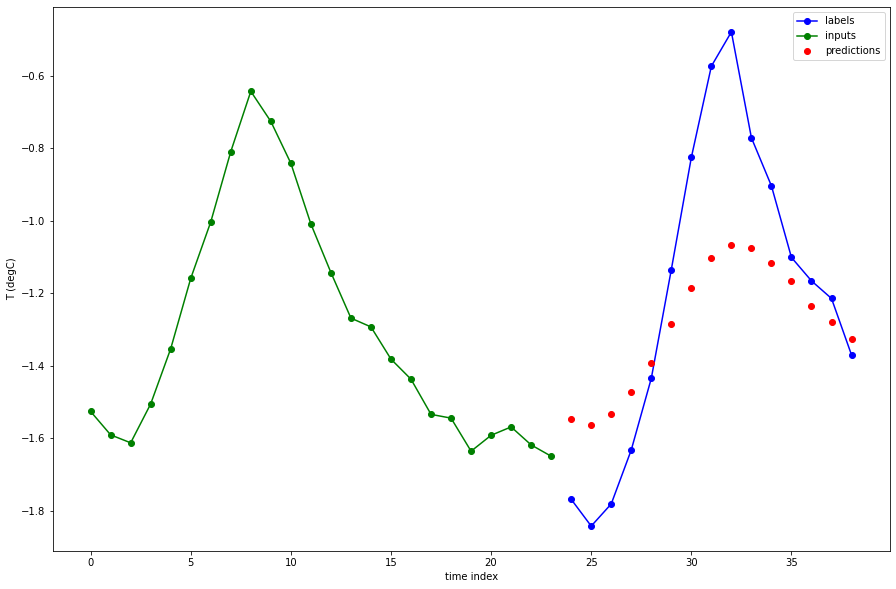

In [346]:
plot_forecast_recursive(model_cur, input_data=inputs_test_c, output_time_step=15, recursive_preds=pr,
               label_data=labels_revived, window=window_cur, plot_col='T (degC)')   

### Direct strategy:

In [105]:
# first step is to create a one step output model

In [106]:
window_cur

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): None
Feature column name (s): None

In [347]:
def direct_datasets(output_time_step=15, 
                input_width=24,label_columns=None, feature_columns=None, 
                train_df=train_df,
                val_df=val_df, 
                test_df=test_df):
    windows = {}
    datasets = {}
    
    for i in range(output_time_step):
        windows [i] = WindowGenerator(
                    input_width=input_width,
                    label_width=1,
                    shift=i+1,
                    label_columns=label_columns,
                    feature_columns=feature_columns)
        datasets["input_train_"+ str(i)], datasets["label_train_"+ str(i)] = windows[i].create_dataset(train_df)
        datasets["input_val_"+ str(i)], datasets["label_val_"+ str(i)] = windows[i].create_dataset(val_df)
        datasets["input_test_"+ str(i)], datasets["label_test_"+ str(i)]  = windows[i].create_dataset(test_df)            
        
    return windows, datasets  


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): None
Feature column name (s): None

In [348]:
def direct_models(model, output_time_step, windows, 
                   data):
        models = {}
        history = {}    
        predictions = {}
        
        for i in range(output_time_step):    
            models[i] = model(window=windows[i])  
            print("Model on time step {} is being trained!".format(i+1))
            input_train, label_train = data['input_train_' + str(i)], data['label_train_' + str(i)]
            input_val, label_val = data['input_val_' + str(i)], data['label_val_' + str(i)]
            input_test, label_test = data['input_test_' + str(i)], data['label_test_' + str(i)]
            history[i] = compile_and_fit(models[i], X=input_train,y=label_train,
                    val_X=input_val, val_y=label_val)              
            IPython.display.clear_output() 
            predictions['train_'+ str(i)] = models[i](input_train)
            predictions['val_'+ str(i)] = models[i](input_val)
            predictions['test_'+ str(i)] = models[i](input_test)
            
        return models, history, predictions

In [349]:
windows, datasets = direct_datasets(output_time_step=15,
                input_width=24,label_columns=None, feature_columns=None, train_df=train_df,
                 val_df=val_df, test_df=test_df)

24 slice(24, None, None) [24]
25 slice(25, None, None) [25]
26 slice(26, None, None) [26]
27 slice(27, None, None) [27]
28 slice(28, None, None) [28]
29 slice(29, None, None) [29]
30 slice(30, None, None) [30]
31 slice(31, None, None) [31]
32 slice(32, None, None) [32]
33 slice(33, None, None) [33]
34 slice(34, None, None) [34]
35 slice(35, None, None) [35]
36 slice(36, None, None) [36]
37 slice(37, None, None) [37]
38 slice(38, None, None) [38]


In [350]:
models, history, predictions = direct_models (model=dense_model, output_time_step=15, windows=windows, data=datasets)

In [353]:
def prediction_label_collect(output_time_step, datasets=datasets, predictions=predictions, data='val'):
    
    dim1, _, dim2 = predictions[data+'_'+str(output_time_step-1)].shape  
    prediction = np.zeros((dim1, output_time_step, dim2))
    labels = np.zeros((dim1, output_time_step, dim2))
    for i in range(output_time_step):
        j = output_time_step - i 
        pred = np.array(predictions[data+'_'+ str(i)])
        label = np.array(datasets['label_'+data+'_'+ str(i)])
        prediction[:, i:i+1, :] = pred[:(pred.shape[0]-(j-1)), :, :] 
        labels[:, i:i+1, :] = label[:(label.shape[0]-(j-1)), :, :] 
    return labels, prediction                   

In [354]:
labels, preds = prediction_label_collect(15, datasets=datasets, predictions=predictions, data='test')

In [355]:
windows.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [359]:
## plot it
def plot_forecast_direct(data='test',
                  labels=labels, output_time_step=10,
                  datasets=datasets,       
                  preds = preds,     
                  windows=windows, plot_col='T (degC)'):
    window = windows[output_time_step-1]
    input_data = datasets['input_'+data+'_'+str(output_time_step-1)]
    
    if labels.shape[2] == 1:
        label_col_index = 0
    elif labels.shape[2] > 1:
        label_col_index = window.column_indices[plot_col]
    print(label_col_index)
        
    if input_data.shape[2] == 1:
        input_col_index = 0
    elif input_data.shape[2] > 1:
        input_col_index = window.column_indices[plot_col]   
    print(input_col_index)
      
    output_index_start = window.input_indices + 1
    label_indices = np.arange(output_index_start[-1], output_time_step + output_index_start[-1])

    plt.plot(label_indices, labels[-2, :, label_col_index], 'bo-',label='labels')
    plt.plot(window.input_indices, input_data[-2, :, input_col_index],'go-', label='inputs')         
    plt.plot(label_indices, preds[-2, :, label_col_index], 'ro', label= 'predictions')
    plt.legend(loc='best')
    plt.xlabel('time index')
    plt.ylabel(plot_col)
    return

1
1


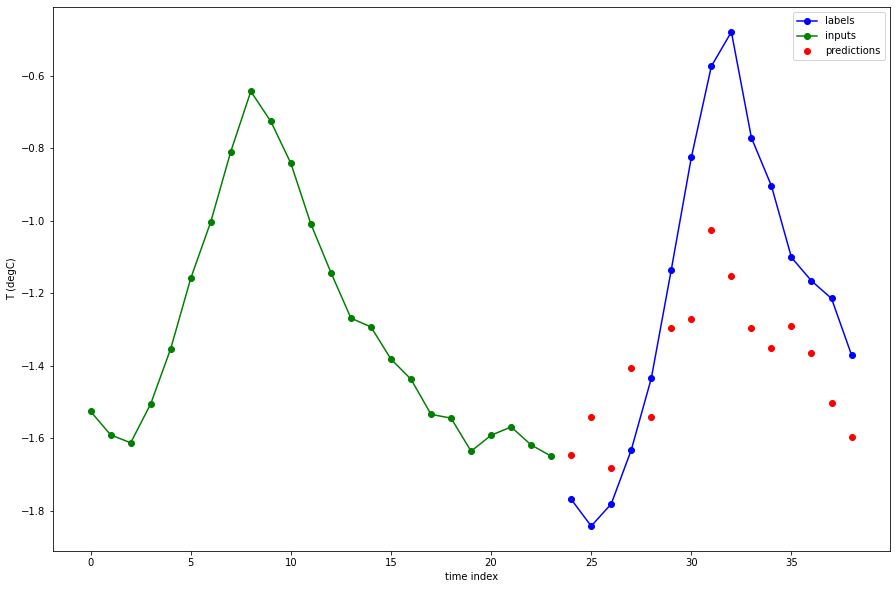

In [360]:
plot_forecast_direct(data='test',
                  labels=labels, output_time_step=15,
                  datasets=datasets,       
                  preds = preds,     
                  windows=windows, plot_col='T (degC)')  

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(mean_squared_error(labels.flatten(), preds.flatten()),
mean_absolute_error (labels.flatten(), preds.flatten()))

0.1837226003581817 0.2657706003135143


1
1


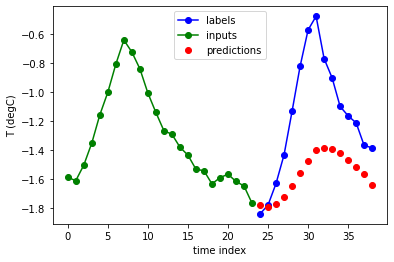

In [121]:
plot_forecast_recursive(model_cur, input_data=inputs_test_c, output_time_step=15, recursive_preds=pr,
               label_data=labels_revived, window=window_cur, plot_col='T (degC)')  

In [122]:
# evaluate the recursive function
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(labels_revived.flatten(), pr.flatten()), mean_absolute_error (labels_revived.flatten(), pr.flatten())

(0.3101511469641496, 0.3492347519617014)

1
1
15


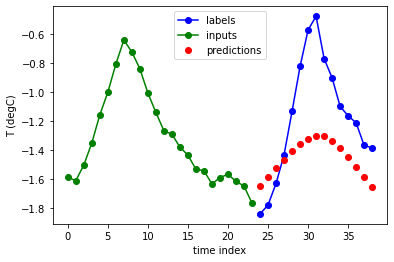

In [123]:
plot_forecast(model, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)') 

In [124]:
print(mean_squared_error(labels_test.flatten(), np.array(model(inputs_test)).flatten()),
mean_absolute_error (labels_test.flatten(), np.array(model(inputs_test)).flatten()))

0.2043992792456811 0.29205595955852826


### Conv NNs:

In [178]:
tf.keras.backend.clear_session()

In [149]:
# multistep models:
conv_window = WindowGenerator(
    input_width=24 , 
    label_width=15,
    shift=15)

In [150]:
conv_window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): None
Feature column name (s): None

In [151]:
window = conv_window
inputs_train, labels_train = window.create_dataset(train_df, shuffle=False)
inputs_val, labels_val = window.create_dataset(val_df, shuffle=False)
inputs_test, labels_test = window.create_dataset(test_df, shuffle=False)

In [152]:
print(inputs_train.shape, labels_train.shape, inputs_val.shape, labels_val.shape)

(49024, 24, 19) (49024, 15, 19) (13979, 24, 19) (13979, 15, 19)


In [153]:
num_input_feature = inputs_train.shape[-1]
num_label_feature = labels_train.shape[-1]

print('num_input_feature: {}, num_label_feature: {}'.format(num_input_feature, num_label_feature))

num_input_feature: 19, num_label_feature: 19


In [154]:
NUM_UNITS = conv_window.label_width * num_label_feature

In [155]:
NUM_UNITS

285

In [156]:
inputs_train.shape[1], inputs_train.shape[2]

(24, 19)

### Conv_model

In [157]:
KERNEL_S = 3

In [158]:
inputs_train.shape

(49024, 24, 19)

In [135]:
a1 = tf.keras.Input(shape=(1, 19))
#concatted = tf.keras.layers.Concatenate()([x1, x2])

a = tf.keras.Input(shape=(24, 19))
b = tf.keras.layers.Lambda(lambda x: x[:, -23:, :])(a)
tf.keras.layers.Concatenate(axis=1)([b, a1])

<KerasTensor: shape=(None, 24, 19) dtype=float32 (created by layer 'concatenate')>

In [159]:
## check output
conv_model = tf.keras.Sequential()
conv_model.add(tf.keras.layers.Conv1D(filters=10,
                           kernel_size=KERNEL_S, 
                           input_shape=(inputs_train.shape[1], inputs_train.shape[2]),
                           activation='relu'))
#conv_model.add(tf.keras.layers.MaxPool1D(pool_size=2))
conv_model.add(tf.keras.layers.Flatten())
conv_model.add(tf.keras.layers.Dropout(0.3))
conv_model.add(tf.keras.layers.Dense(units=NUM_UNITS, kernel_initializer=tf.initializers.RandomNormal))
conv_model.add(tf.keras.layers.Reshape([conv_window.label_width, num_label_feature]))


In [160]:
conv_model.output

<KerasTensor: shape=(None, 15, 19) dtype=float32 (created by layer 'reshape')>

In [181]:
def conv_model(window, filters=10, kernel_size=3):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu'),        
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(units=(window.label_width * window.number_label_features)),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
     tf.keras.layers.Reshape([window.label_width, window.number_label_features])
                               ])
    return model

In [143]:
window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): None
Feature column name (s): None

In [163]:
conv_model = conv_model(window, filters=10, kernel_size=3)

In [164]:
history = compile_and_fit(conv_model, X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val)

IPython.display.clear_output()
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 10)            580       
_________________________________________________________________
flatten (Flatten)            (None, 220)               0         
_________________________________________________________________
dense (Dense)                (None, 285)               62985     
_________________________________________________________________
reshape (Reshape)            (None, 15, 19)            0         
Total params: 63,565
Trainable params: 63,565
Non-trainable params: 0
_________________________________________________________________


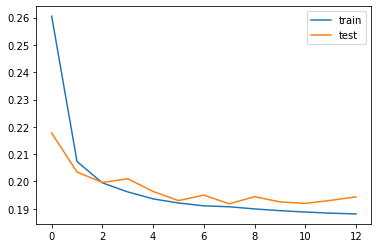

In [166]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [167]:
history.history['val_loss'][0], history.history['val_loss'][-1]

(0.21775245666503906, 0.19438797235488892)

In [168]:
results = conv_model.evaluate(inputs_test, labels_test)
results

218/218 [==============================] - 0s 659us/step - loss: 0.1818 - mean_absolute_error: 0.2636


[0.18181228637695312, 0.2635830342769623]

1
1
15


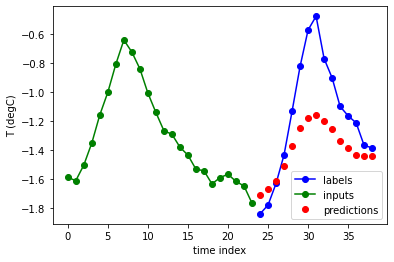

In [169]:
plot_forecast(conv_model, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)')     

In [170]:
print(mean_squared_error(labels_test.flatten(), np.array(conv_model(inputs_test)).flatten()),
mean_absolute_error (labels_test.flatten(), np.array(conv_model(inputs_test)).flatten()))

0.18181220274748291 0.26358294766016205


### Conv_recursive:

In [182]:
# multistep models:
conv_re = WindowGenerator(
    input_width=24 , 
    label_width=1,
    shift=1)



inputs_train_re, labels_train_re = conv_re.create_dataset(train_df, shuffle=False)
inputs_val_re, labels_val_re = conv_re.create_dataset(val_df, shuffle=False)
inputs_test_re, labels_test_re = conv_re.create_dataset(test_df, shuffle=False)

print(inputs_train_re.shape, labels_train_re.shape, inputs_val_re.shape, labels_val_re.shape)

(49038, 24, 19) (49038, 1, 19) (13993, 24, 19) (13993, 1, 19)


In [183]:
conv_re

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): None
Feature column name (s): None

In [184]:
conv_model_cur = conv_model(conv_re, filters=10, kernel_size=3)

In [185]:
history = compile_and_fit(conv_model_cur, X=inputs_train_re,y=labels_train_re,
                    val_X=inputs_val_re, val_y=labels_val_re, patience=5,
                    batch_size=32, max_epochs=30 )

IPython.display.clear_output()

conv_model_cur.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 10)            580       
_________________________________________________________________
flatten (Flatten)            (None, 220)               0         
_________________________________________________________________
dense (Dense)                (None, 19)                4199      
_________________________________________________________________
reshape (Reshape)            (None, 1, 19)             0         
Total params: 4,779
Trainable params: 4,779
Non-trainable params: 0
_________________________________________________________________


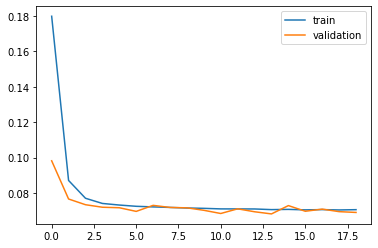

In [187]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [188]:
pr = recursive_model(conv_model_cur, inputs_test_re, output_time_step=15)

In [189]:
labels_revived = revive_labels_recursive(15, labels=labels_test_re, predictions=pr)
              

1
1


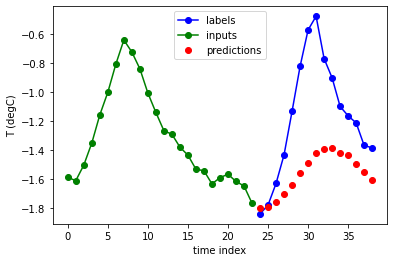

In [192]:
plot_forecast_recursive(conv_model_cur, input_data=inputs_test_re, output_time_step=15, recursive_preds=pr,
               label_data=labels_revived, window=conv_re, plot_col='T (degC)')  

In [193]:
mean_squared_error(labels_revived.flatten(), pr.flatten()), mean_absolute_error (labels_revived.flatten(), pr.flatten())

(0.3296058825710696, 0.37058495293576255)

### Conv forecast direct

In [194]:
windows, datasets = direct_datasets(output_time_step=15,
                input_width=24,label_columns=None, feature_columns=None, train_df=train_df,
                 val_df=val_df, test_df=test_df)

In [195]:
models, history, predictions = direct_models(model=conv_model, output_time_step=15, windows=windows, data=datasets)

In [196]:
labels, preds = prediction_label_collect(15, datasets=datasets, predictions=predictions, data='test')

1
1


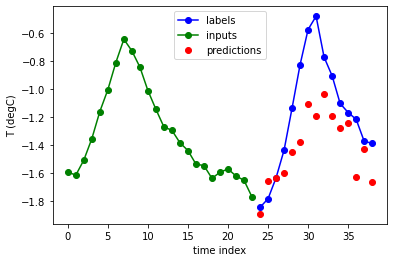

In [198]:
plot_forecast_direct(data='test',
                  labels=labels, output_time_step=15,
                  datasets=datasets,       
                  preds = preds,     
                  windows=windows, plot_col='T (degC)')  

In [199]:
print(mean_squared_error(labels.flatten(), preds.flatten()),
mean_absolute_error (labels.flatten(), preds.flatten()))

0.1792938096062937 0.25926425165356937


### Conv_Autoregressive

In [219]:
tf.keras.backend.clear_session()

In [214]:
window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): None
Feature column name (s): None

In [228]:
window.input_width, window.number_input_features, window.number_label_features, window.label_width


(24, 19, 19, 15)

In [227]:
def conv_model_regressive(filters=10, kernel_s=3, activation='relu',
                         num_label_feature=window.number_label_features,
                         output_time_step=window.label_width,
                         input_time_steps=window.input_width,
                         input_features=window.number_input_features):
    
    # global layers
      
    Input_layer = tf.keras.Input(shape=(input_time_steps, input_features))
    Conv_layer = tf.keras.layers.Conv1D(filters= filters,kernel_size=kernel_s,
                           activation=activation)
    Flatten_layer = tf.keras.layers.Flatten()
    Dense_layer = tf.keras.layers.Dense(num_label_feature)
    Reshape_layer = tf.keras.layers.Reshape([1, num_label_feature])
    Lambda_layer = tf.keras.layers.Lambda(lambda x: x[:, -(input_time_steps-1):, :])
    concat_layer = tf.keras.layers.Concatenate(axis=1)
    
    #warm up   
    def Conv_round(Input_layer):
        output = Conv_layer(Input_layer)
        output = Flatten_layer(output)
        prediction = Dense_layer(output)   
        return prediction
    
    predictions = []    
        
  # Insert the first prediction
    prediction = Conv_round(Input_layer)
    predictions.append(prediction)
    
    for n in range(1, output_time_step):
    # Use the last prediction as input.
        x1 = prediction
        x1 = Reshape_layer(x1)
        x2 = Lambda_layer(Input_layer)         
        x3 = concat_layer([x2, x1])
        
    # Execute one Conv block.
        prediction = Conv_round(x3) 
        predictions.append(prediction)
    
  # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    model = tf.keras.Model(inputs=Input_layer, outputs=predictions)
    return model


In [229]:
model_reg = conv_model_regressive()

In [230]:
model_reg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 19)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 22, 10)       580         input_4[0][0]                    
                                                                 concatenate_3[0][0]              
                                                                 concatenate_3[1][0]              
                                                                 concatenate_3[2][0]              
                                                                 concatenate_3[3][0]              
                                                                 concatenate_3[4][0]        

In [231]:
history = compile_and_fit(model_reg,
                          X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val)

IPython.display.clear_output()

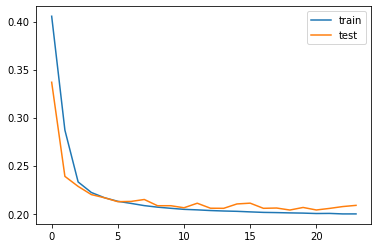

In [232]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [234]:
results = model_reg.evaluate(inputs_test, labels_test)

218/218 [==============================] - 0s 1ms/step - loss: 0.1977 - mean_absolute_error: 0.2864


1
1
15


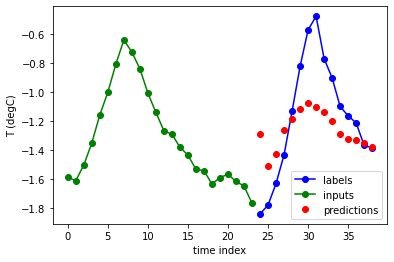

In [235]:
plot_forecast(model_reg, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)') 

### LSTM

In [321]:
# multistep models:
window = WindowGenerator(
    input_width=24 , 
    label_width=15,
    shift=15,
 label_columns=None,
 feature_columns=None)

In [333]:
window = window
inputs_train, labels_train = window.create_dataset(train_df, shuffle=False)
inputs_val, labels_val = window.create_dataset(val_df, shuffle=False)
inputs_test, labels_test = window.create_dataset(test_df, shuffle=False)

In [323]:
print(inputs_train.shape, labels_train.shape, inputs_val.shape, labels_val.shape)

(49024, 24, 19) (49024, 15, 19) (13979, 24, 19) (13979, 15, 19)


### Normal vector output LSTM

In [336]:

tf.keras.backend.clear_session()

In [335]:
def LSTM_model_vec_out(window, units=10):
    model = tf.keras.Sequential([        
        tf.keras.layers.LSTM(units, return_sequences=False)  ,  
        tf.keras.layers.Dense(units=(window.label_width * window.number_label_features)),
        tf.keras.layers.Reshape([window.label_width, window.number_label_features])  
    ])
    
    return model

In [317]:
## check output
LSTM_model_vec = tf.keras.Sequential()
LSTM_model_vec.add(tf.keras.layers.LSTM(10,input_shape=(inputs_train.shape[1], inputs_train.shape[2]),
                                    return_sequences=False))
LSTM_model_vec.add(tf.keras.layers.Dense(units=NUM_UNITS))
LSTM_model_vec.add(tf.keras.layers.Reshape([window.label_width, num_label_feature]))

In [338]:
window.number_label_features

19

In [339]:
model_vector = LSTM_model_vec_out(window, units=10)

In [340]:
history = compile_and_fit(model_vector, X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val)

IPython.display.clear_output()


In [341]:
model_vector.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1200      
_________________________________________________________________
dense (Dense)                (None, 285)               3135      
_________________________________________________________________
reshape (Reshape)            (None, 15, 19)            0         
Total params: 4,335
Trainable params: 4,335
Non-trainable params: 0
_________________________________________________________________


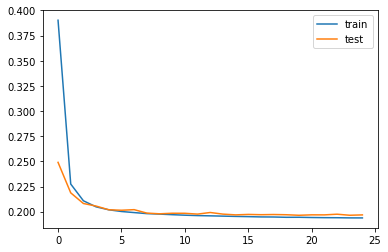

In [342]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [343]:
results = model_vector.evaluate(inputs_test, labels_test)
results

218/218 [==============================] - 0s 1ms/step - loss: 0.1870 - mean_absolute_error: 0.2729


[0.1869729906320572, 0.2728896737098694]

1
1
15


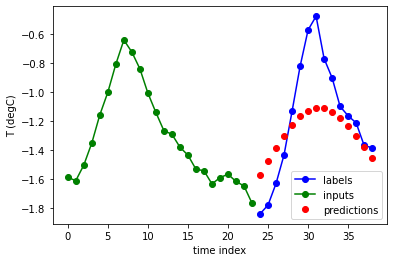

In [344]:
plot_forecast(model_vector, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)') 

### Encoder-decoder LSTM

In [345]:
# clear model
tf.keras.backend.clear_session()

In [301]:
window.number_label_features

19

In [346]:
def LSTM_model_encoder_decoder(window, encoder_units=10, decoder_units=10):
    model = tf.keras.Sequential([        
        tf.keras.layers.LSTM(encoder_units,return_sequences=False)  ,  
        tf.keras.layers.RepeatVector(window.label_width),
        tf.keras.layers.LSTM(decoder_units, return_sequences=True),
        tf.keras.layers.Dense(window.number_label_features)
     ])
    
    return model

In [152]:
# clear model
tf.keras.backend.clear_session()

## check output  
LSTM_model_en = tf.keras.Sequential()
LSTM_model_en.add(tf.keras.layers.LSTM(10, input_shape=(inputs_train.shape[1], inputs_train.shape[2])))
LSTM_model_en.add(tf.keras.layers.RepeatVector(window.label_width))
LSTM_model_en.add(tf.keras.layers.LSTM(10, return_sequences=True))
LSTM_model_en.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_label_feature)))                         


In [154]:
LSTM_model_en.output

<KerasTensor: shape=(None, 24, 19) dtype=float32 (created by layer 'time_distributed')>

In [347]:
model_en = LSTM_model_encoder_decoder(window)

In [348]:
history = compile_and_fit(model_en, X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val)

IPython.display.clear_output()


In [349]:
model_en.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1200      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 10)            840       
_________________________________________________________________
dense (Dense)                (None, 15, 19)            209       
Total params: 2,249
Trainable params: 2,249
Non-trainable params: 0
_________________________________________________________________


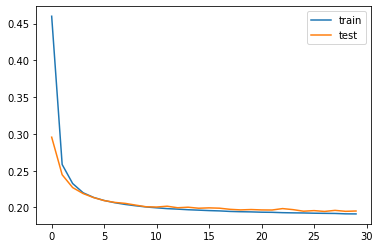

In [350]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [351]:
results = model_en.evaluate(inputs_test, labels_test)
results

218/218 [==============================] - 0s 2ms/step - loss: 0.1863 - mean_absolute_error: 0.2749


[0.1862632930278778, 0.27493998408317566]

1
1
15


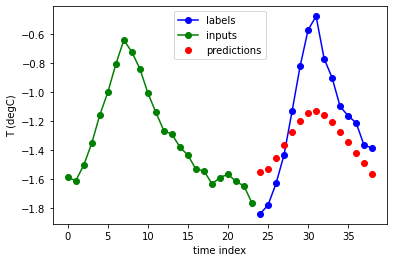

In [352]:
plot_forecast(model_en, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)') 

### Autoregressive LSTM:

In [354]:
# clear model
tf.keras.backend.clear_session()

In [355]:
def LSTM_model_Recursive(LSTM_units=10,
                         num_label_feature=window.number_label_features,
                         output_time_step=window.label_width,
                         input_time_steps=window.input_width,
                         input_features=window.number_input_features):
    
    # global layers
    Input_layer = tf.keras.Input(shape=(input_time_steps, input_features))
    LSTM_layer = tf.keras.layers.LSTM(LSTM_units, return_state=True)
    #LSTM_cell = tf.keras.layers.LSTMCell(LSTM_units)
    #LSTM_RNN = tf.keras.layers.RNN(LSTM_cell, return_state=True)
    Reshape_layer = tf.keras.layers.Reshape((1,num_label_feature))
    Dense_layer = tf.keras.layers.Dense(num_label_feature)
    
    #warm up    
    output, *state = LSTM_layer(Input_layer)
    #output, *state = LSTM_RNN(Input_layer)
    prediction = Dense_layer(output)   

    predictions = []    
        
  # Insert the first prediction
    predictions.append(prediction)

    for n in range(1, output_time_step):
    # Use the last prediction as input.
        x = prediction
        x = Reshape_layer(x)  
    # Execute one lstm step.
        x, *state = LSTM_layer(x, initial_state=state)
        #x, state = LSTM_cell(x, states=state)
    # Convert the lstm output to a prediction.
        prediction = Dense_layer(x)
    # Add the prediction to the output
        predictions.append(prediction)
  # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    model = tf.keras.Model(inputs=Input_layer, outputs=predictions)
    return model

In [356]:
model_reg = LSTM_model_Recursive(LSTM_units=10)

In [357]:
history = compile_and_fit(model_reg,
                          X=inputs_train,y=labels_train,
                    val_X=inputs_val, val_y=labels_val)

IPython.display.clear_output()

In [358]:
model_reg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 19)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10), (None,  1200        input_1[0][0]                    
                                                                 reshape[0][0]                    
                                                                 lstm[0][1]                       
                                                                 lstm[0][2]                       
                                                                 reshape[1][0]                    
                                                                 lstm[1][1]                   

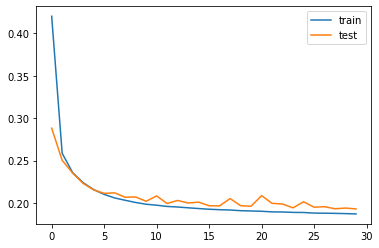

In [359]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [360]:
results = model_reg.evaluate(inputs_test, labels_test)

218/218 [==============================] - 1s 3ms/step - loss: 0.1814 - mean_absolute_error: 0.2682


1
1
15


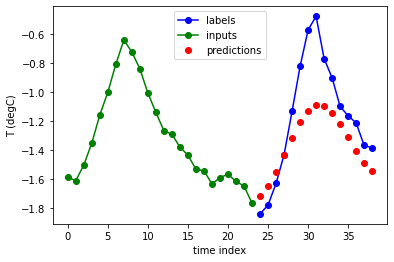

In [361]:
plot_forecast(model_reg, input_data=inputs_test,
               label_data=labels_test, window=window, plot_col='T (degC)') 

### Recursive LSTM

In [ ]:
# clear model
tf.keras.backend.clear_session()

In [367]:
# multistep models:
LSTM_re = WindowGenerator(
    input_width=24 , 
    label_width=1,
    shift=1)



inputs_train_re, labels_train_re = LSTM_re.create_dataset(train_df, shuffle=False)
inputs_val_re, labels_val_re = LSTM_re.create_dataset(val_df, shuffle=False)
inputs_test_re, labels_test_re = LSTM_re.create_dataset(test_df, shuffle=False)

print(inputs_train_re.shape, labels_train_re.shape, inputs_val_re.shape, labels_val_re.shape)

(49038, 24, 19) (49038, 1, 19) (13993, 24, 19) (13993, 1, 19)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                1200      
_________________________________________________________________
dense_3 (Dense)              (None, 19)                209       
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 19)             0         
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


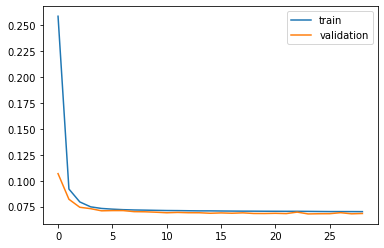

In [368]:
LSTM_model_cur = LSTM_model_vec_out(LSTM_re, units=10)

history = compile_and_fit(LSTM_model_cur, X=inputs_train_re,y=labels_train_re,
                    val_X=inputs_val_re, val_y=labels_val_re, patience=5,
                    batch_size=32, max_epochs=30 )

IPython.display.clear_output()

LSTM_model_cur.summary()

import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();



1
1


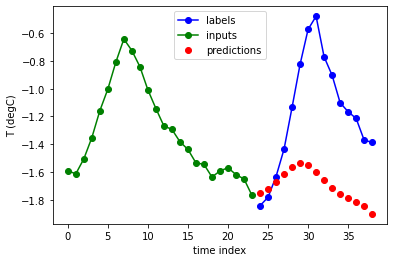

In [385]:
pr = recursive_model(LSTM_model_cur, inputs_test_re, output_time_step=15)

labels_revived = revive_labels_recursive(15, labels=labels_test_re, predictions=pr)
              

plot_forecast_recursive(LSTM_model_cur , input_data=inputs_test_re, output_time_step=15, recursive_preds=pr,
               label_data=labels_revived, window=conv_re, plot_col='T (degC)')  



In [386]:
mean_squared_error(labels_revived.flatten(), pr.flatten()), mean_absolute_error (labels_revived.flatten(), pr.flatten())

(0.24140205023753808, 0.3296945670354629)

### Direct LSTM

In [372]:
LSTM_model_vec_out

<function __main__.LSTM_model_vec_out(window, units=10)>

In [373]:
windows, datasets = direct_datasets(output_time_step=15,
                input_width=24,label_columns=None, feature_columns=None, train_df=train_df,
                 val_df=val_df, test_df=test_df)

models, history, predictions = direct_models(model=LSTM_model_vec_out, output_time_step=15, windows=windows, data=datasets)



In [380]:
labels, preds = prediction_label_collect(15, datasets=datasets, predictions=predictions, data='test')
 



1
1


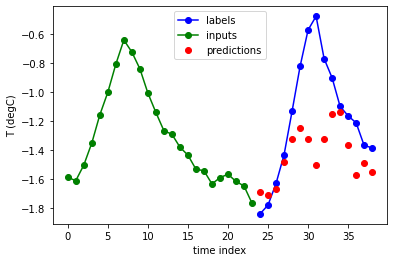

In [381]:
plot_forecast_direct(data='test',
                  labels=labels, output_time_step=15,
                  datasets=datasets,       
                  preds = preds,     
                  windows=windows, plot_col='T (degC)') 

In [387]:
print(mean_squared_error(labels.flatten(), preds.flatten()),
mean_absolute_error (labels.flatten(), preds.flatten()))

0.17328113628697303 0.255616167752952
